## Notebook on Verlet 

Notebook prepared by F. Troni - Course of Statistical Mechanics (Kigali, 03/2025)

In this notebook we study the two algorithms known as Verlet and Velocity Verlet. We test it on a 1D toy model that consists of a particle moving under the effect of an harmonic potential.

**Theory:** section 3.8.1, 3.8.2, 3.8.3

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt

### The system ###

Setting of the variables

In [2]:
# constants
k = 1                  # a.u. - spring constant
m = 1                  # a.u. - mass of the particle
omega = np.sqrt(k / m) # a.u. - frequency
kB = 3.1668 * 1e-6     # Eh/K - Boltzmann constant

# simulation parameters
Np = 1                 # number of particles
dt = 0.01              # a.u. - time-step
N_steps = 1000         # number of steps
T = 300                # K - temperature

# initial conditions
x0 = 0                              # initial position
std = np.sqrt(kB * T / m)           # standard deviation to extract the initial velocity according to Maxwell-Boltzmann distribution
v0 = np.random.normal(0, scale=std) # initial velocity
A = v0 / omega                      # amplitude of the analytical solution


Functions: potential and analytical solution

In [3]:
# harmonic oscillator potential
def V(x):
    return 0.5 * k * x**2

# harmonic oscillator function
def force(x):
    return - k * x

# analytical solution for the trajectory
def x_analytical(t):
    return A * np.sin(omega * t)

# analytical solution for the velocity
def v_analytical(t):
    return A * omega * np.cos(omega * t)

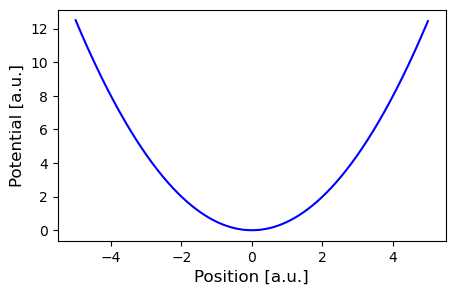

In [4]:
x_test = np.arange(-5, 5, 0.01)

plt.figure(figsize=(5, 3))
plt.plot(x_test, V(x_test), 'b', linestyle='-')
plt.ylabel('Potential [a.u.]', fontsize=12)
plt.xlabel('Position [a.u.]', fontsize=12)
plt.show()    

#### Integrators

**Verlet algorithm:**

$x(t + \Delta t) = 2x(t) - x(t - \Delta t) + \frac{F(t)}{m} \Delta t^2$

Error ~$\mathcal{O}(\Delta t^4)$

In [5]:
# Verlet - current = t, old = t - dt
def verlet(x_current, x_old, F_current):
    # store current position in a temporary variable to update it without losing its value for the next step
    tmp = x_current

    # update the position (t -> t + dt)
    x_current = 2 * x_current - x_old + (F_current / m) * dt**2
    
    # update previous position with the one at time t for the next step
    x_old = tmp

    # update previous position with the one at time t + 1 for the next step
    F_current = force(x_current)

    return x_current, x_old, F_current 

**Velocity Verlet algorithm:**

$v(t + \Delta t / 2) = v(t) + \frac{1}{2}\frac{F(t)}{m}\Delta t$

$x(t + \Delta t) = x(t) + v(t + \delta t/2)\Delta t$

$v(t + \Delta t) = v(t + \Delta t / 2) + \frac{1}{2}\frac{F(t + \Delta t)}{m}\Delta t$


Error ~$\mathcal{O}(\Delta t^2)$

In [6]:
# Velocity Verlet - current = t
def velocity_verlet(x_current, v_current, F_current):
    # half-step update of the velocity (t -> t + dt/2)
    v_half_step = v_current + 0.5 * (F_current / m) * dt

    # update of the position (t -> t + dt)
    x_current = x_current + v_half_step * dt

    # update of the force at time t + dt
    F_current = force(x_current)

    # half-step update of the velocity (t + dt/2 -> t + dt)
    v_current = v_half_step + 0.5 * (F_current / m) * dt
    
    return x_current, v_current, F_current

### The simulation ###


#### Analytical solution

In [7]:
# analytical solution
time = np.arange(0, N_steps * dt, dt)

x_vec_analytical = [x_analytical(t) for t in time]
v_vec_analytical = [v_analytical(t) for t in time]

x_vec_analytical = np.array(x_vec_analytical)
v_vec_analytical = np.array(v_vec_analytical)

#### Verlet algorithm

In [8]:
# Verlet
x_vec = np.zeros(N_steps + 1)

# step 0
F = force(x0)
x_old = x0


For Verlet I need two initial steps! How do I get the position at time $t + \delta t$? I can use Taylor expansion with an error of order ~$\mathcal{O}(\delta t^3)$. 

**Question:** Can this constitute a problem?

In [9]:
# first step for Verlet
x = x0 + v0 * dt + 0.5 * (F / m) * dt**2
F = force(x)

In [10]:
# storing vectors
x_vec = np.zeros(N_steps)
v_vec = np.zeros(N_steps - 1) # why different?

# store step 0 and 1 as first steps of our simulation
x_vec[0] = x0
x_vec[1] = x
    
for n in range(2, N_steps):
    x, x_old, F = verlet(x, x_old, F)
    x_vec[n] = x

**Question:** Why am I computing the velocities separated from the positions?

In [11]:
# now we compute the velocity a posteriori!
v_vec[0] = v0

for n in range(1, N_steps - 1):
    v_vec[n] = 0.5 * (x_vec[n + 1] - x_vec[n - 1]) / dt    

##### Plotting functions

In [12]:
def plot_position(time, x, x_analytical):
    plt.figure(figsize=(5, 3))
    plt.plot(time, x_analytical, 'r', linestyle='-', label='Analytical')
    plt.plot(time, x, 'b', linestyle=':', label='Numerical')
    plt.ylabel('Position [a.u.]', fontsize=12)
    plt.xlabel('Time [a.u.]', fontsize=12)
    plt.legend(frameon=True, fontsize=8)
    plt.show()
    
def plot_velocity(time, v, v_analytical):
    plt.figure(figsize=(5, 3))
    plt.plot(time, v_analytical, 'r', linestyle='-', label='Analytical')
    plt.plot(time, v, 'b', linestyle=':', label='Numerical')
    plt.ylabel('Velocity [a.u.]', fontsize=12)
    plt.xlabel('Time [a.u.]', fontsize=12)
    plt.legend(frameon=True, fontsize=8)
    plt.show()

def plot_energy(time, x, v):
    kinetic_energy = 0.5 * m * v**2
    potential_energy = V(x)
    tot_energy = kinetic_energy + potential_energy

    plt.figure(figsize=(5, 3))
    plt.plot(time, kinetic_energy, 'g', linestyle='-', label='Kinetic')
    plt.plot(time, potential_energy, 'b', linestyle='-', label='Potential')
    plt.plot(time, tot_energy, 'r', linestyle='-', label='Total')
    plt.ylabel('Energy [a.u.]', fontsize=12)
    plt.xlabel('Time [a.u.]', fontsize=12)
    plt.legend(frameon=True, fontsize=8)
    plt.show()

def plot_cons_energy(time, x, v, x_analytical, v_analytical):
    kinetic_energy = 0.5 * m * v**2
    potential_energy = V(x)
    tot_energy = kinetic_energy + potential_energy

    v_analytical = np.array(v_analytical)
    kinetic_energy_analytical = 0.5 * m * v_analytical**2
    potential_energy_analytical = V(x_analytical)
    tot_energy_analytical = kinetic_energy_analytical + potential_energy_analytical

    plt.figure(figsize=(5, 3))
    plt.plot(time, tot_energy_analytical, 'r', linestyle='-', label='Analytical')
    plt.plot(time, tot_energy, 'b', linestyle=':', label='Numerical')
    plt.ylabel('Energy [a.u.]', fontsize=12)
    plt.xlabel('Time [a.u.]', fontsize=12)
    plt.legend(frameon=True, fontsize=8)
    plt.show()

def plot_temperature(time, v):
    temperature = m * v**2 / (3 * kB * Np)
    plt.figure(figsize=(5, 3))
    plt.plot(time, temperature, 'g', linestyle='-', label='T')
    plt.ylabel('Temperature [K]', fontsize=12)
    plt.xlabel('Time [a.u.]', fontsize=12)
    plt.legend(frameon=True, fontsize=8)
    plt.show()

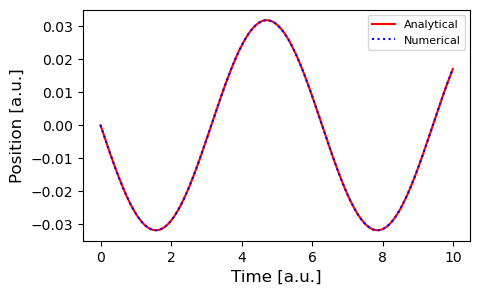

In [13]:
plot_position(time, x_vec, x_vec_analytical)

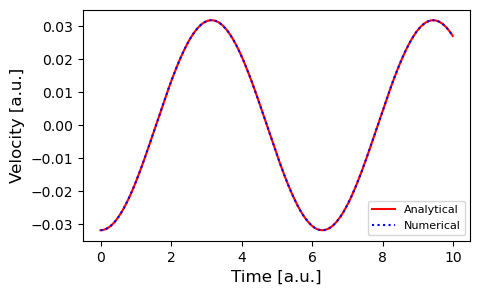

In [14]:
plot_velocity(time[:-1], v_vec, v_vec_analytical[:-1])

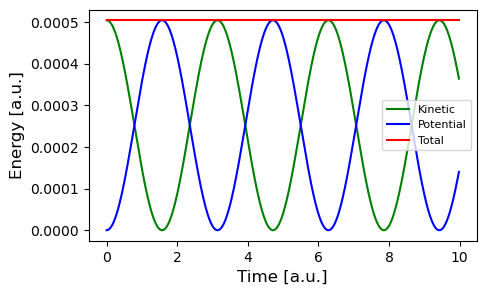

In [15]:
plot_energy(time[:-1], x_vec[:-1], v_vec)

**Question:** what should we notice in the energy plot?

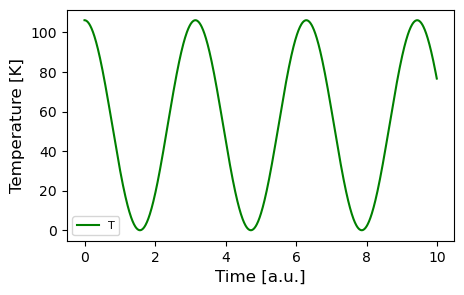

In [16]:
plot_temperature(time[:-1], v_vec)

#### Velocity Verlet algorithm

In [17]:
# storing vectors
x_vec = np.zeros(N_steps)
v_vec = np.zeros(N_steps)

F = force(x0)

# just need initial position and velocity!
x = x0
v = v0

x_vec[0] = x
v_vec[0] = v
    
for n in range(1, N_steps):
    x, v, F = velocity_verlet(x, v, F) # velocities computed together with the position!
    x_vec[n] = x
    v_vec[n] = v

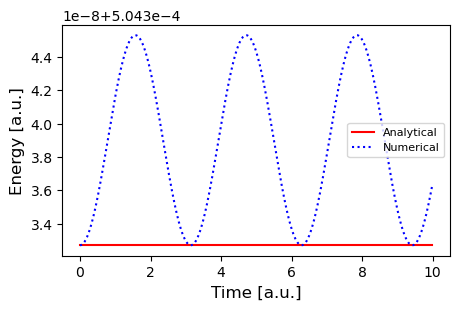

In [18]:
plot_cons_energy(time, x_vec, v_vec, x_vec_analytical, v_vec_analytical)


**Question:** Why do you think that we observe oscillations in the energy?

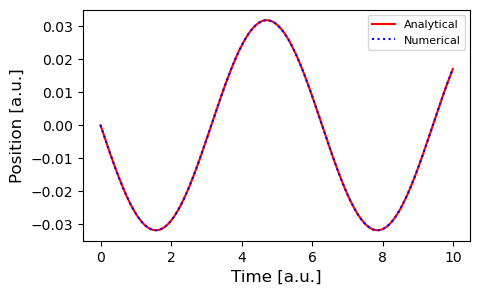

In [19]:
plot_position(time, x_vec, x_vec_analytical)

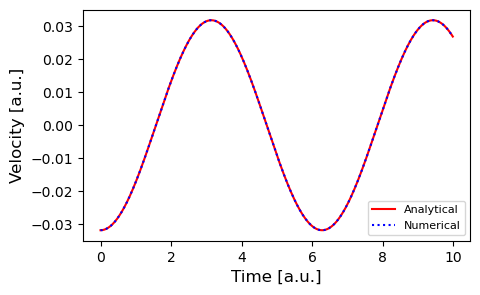

In [20]:
plot_velocity(time, v_vec, v_vec_analytical)

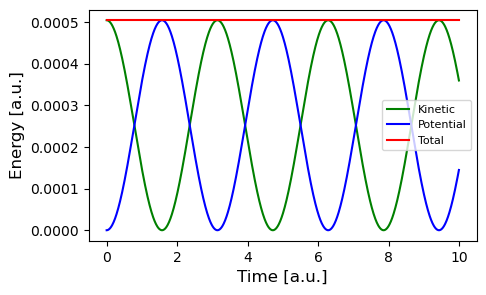

In [21]:
plot_energy(time, x_vec, v_vec)

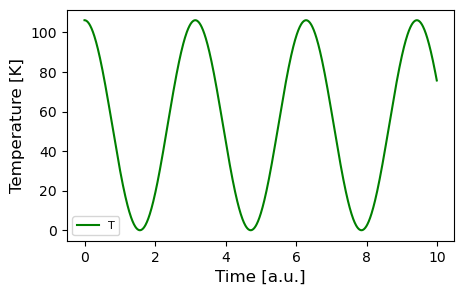

In [22]:
plot_temperature(time, v_vec)